<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/sun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solar Astronomy - Analysis of Sun**

In [3]:
!pip install sunpy reproject mpl_animators -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from scipy import ndimage

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.mpl_normalize import ImageNormalize

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.map.maputils import all_coordinates_from_map

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Sample data
aia = sunpy.map.Map(AIA_171_IMAGE)

*Find and mask the brightest pixel*

In [6]:
# Find maximum in AIA image data then transform that pixel coordinate to a map coordinate
pixel_pos = np.argwhere(aia.data == aia.data.max()) * u.pixel
hpc_max = aia.wcs.pixel_to_world(pixel_pos[:, 1], pixel_pos[:, 0])

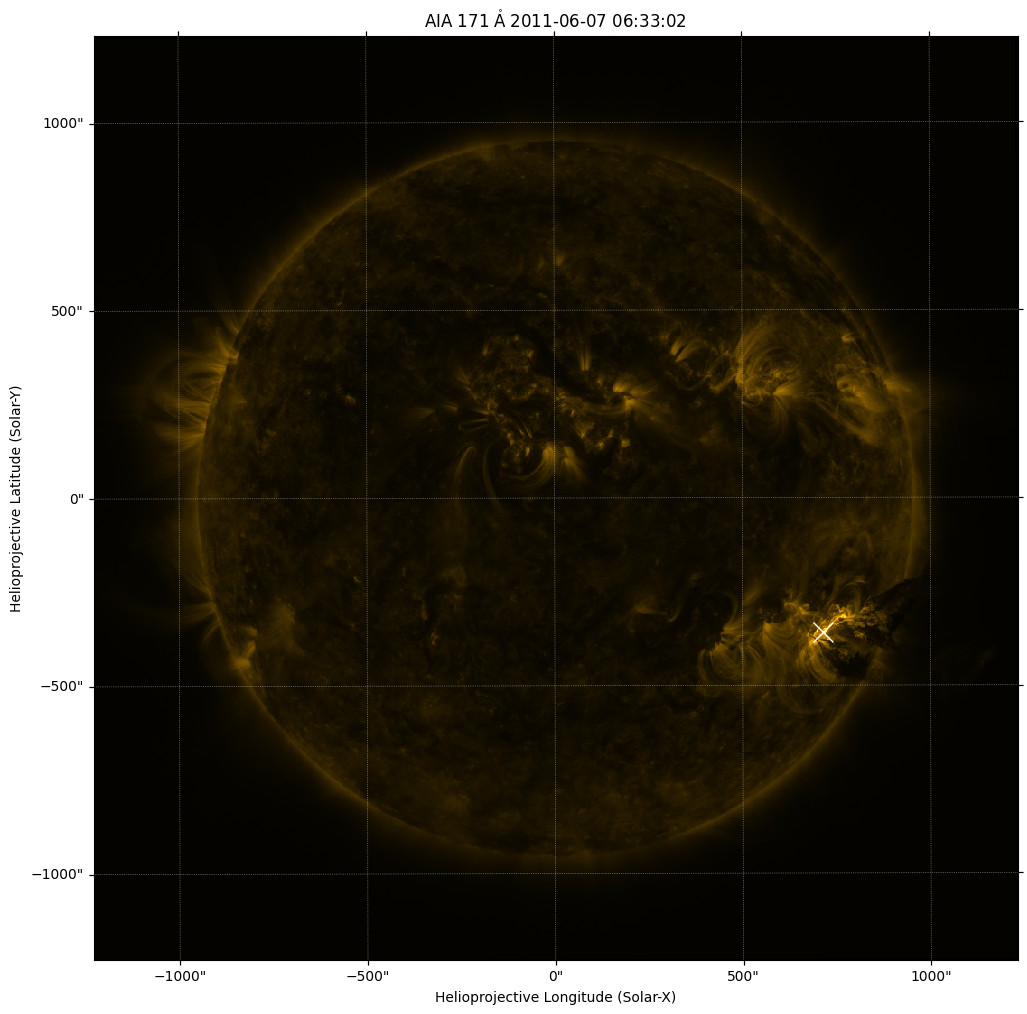

In [7]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(projection=aia)

aia.plot(axes=ax)
ax.plot_coord(hpc_max, color='white', marker='x', markersize=15)

plt.show()

In [15]:
# A utility function gives us access to the helioprojective coordinate of each pixels.
# We create a new array which contains the normalized radial position for each pixel adjusted
# for the position of the brightest pixel (using hpc_max) and then create a new map.
hpc_coords = all_coordinates_from_map(aia)
r_mask = np.sqrt((hpc_coords.Tx - hpc_max.Tx) ** 2 +
                 (hpc_coords.Ty - hpc_max.Ty) ** 2) / aia.rsun_obs
mask = ma.masked_less_equal(r_mask, 0.1)
scaled_map = sunpy.map.Map(aia.data, aia.meta, mask=mask.mask)

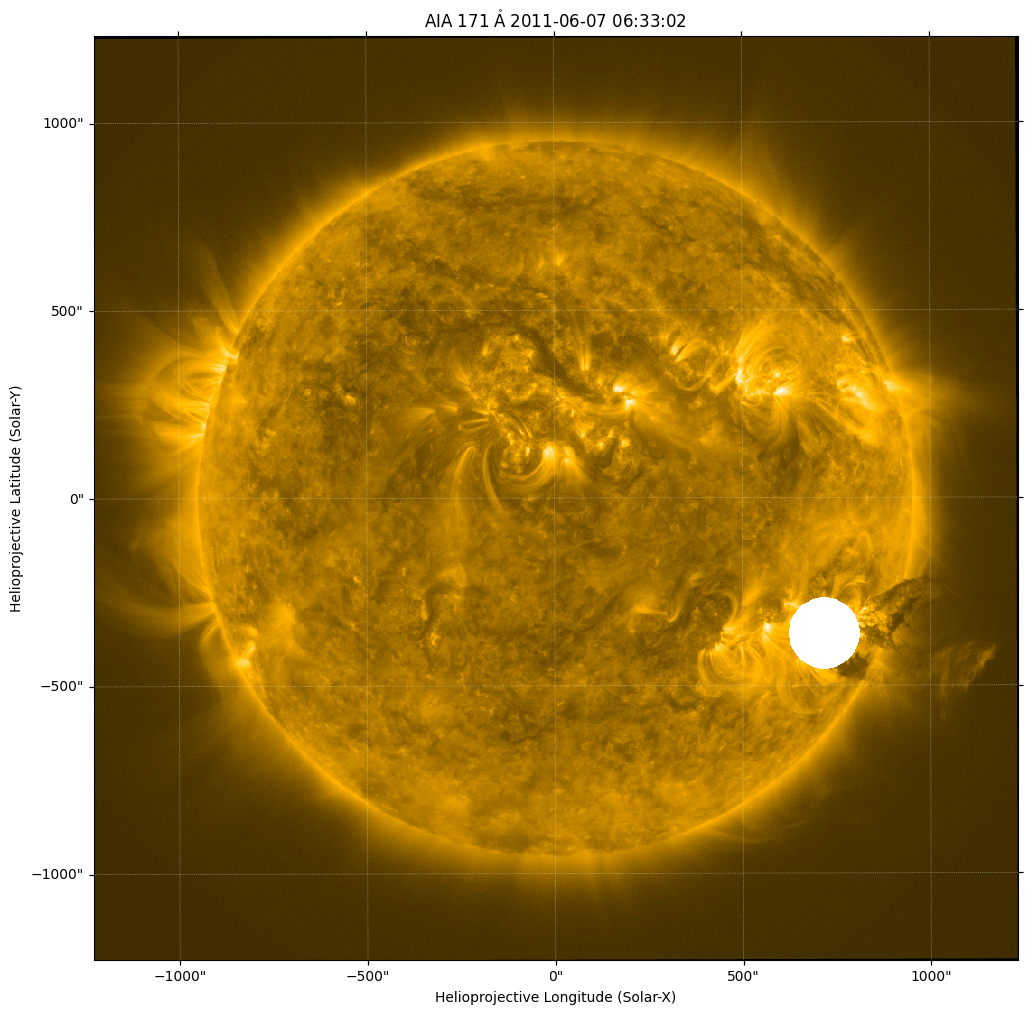

In [9]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(projection=scaled_map)
scaled_map.plot(axes=ax)
plt.show()

*Edge Enhancing Coronal Loops*

In [10]:
# sample data and crop it down to a region featuring coronal loops
aia = sunpy.map.Map(AIA_171_IMAGE)
bottom_left = SkyCoord(750 * u.arcsec, -200 * u.arcsec, frame=aia.coordinate_frame)
top_right = SkyCoord(1500 * u.arcsec, 550 * u.arcsec, frame=aia.coordinate_frame)
aia_smap = aia.submap(bottom_left, top_right=top_right)

In [11]:
# apply an edge enhance filter to the data in both x and y directions and combine the two images together
sx = ndimage.sobel(aia_smap.data, axis=0, mode='constant')
sy = ndimage.sobel(aia_smap.data, axis=1, mode='constant')
edge_enhanced_im = np.hypot(sx, sy)

In [12]:
# create a new map with the edge enhanced data
edge_map = sunpy.map.Map(edge_enhanced_im, aia_smap.meta)

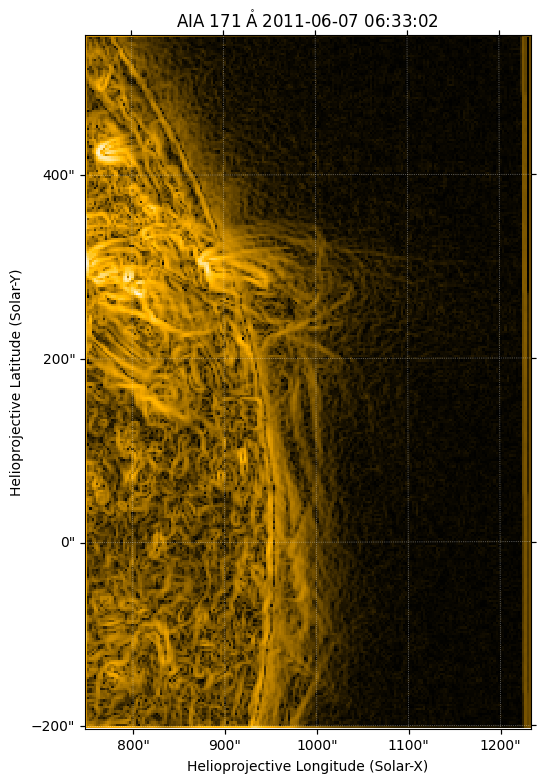

In [13]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection=edge_map)
edge_map.plot(axes=ax)
plt.show()

*Enhancing off-disk emission (enhance emission above the limb)*

In [17]:
# Sample data
aia = sunpy.map.Map(AIA_171_IMAGE)

In [18]:
# A utility function gives access to helioprojective coordinate of each pixels
# Use that to create a new array which contains normalized radial position for each pixel
hpc_coords = all_coordinates_from_map(aia)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / aia.rsun_obs

In [19]:
# Check how emission above limb depends on distance
rsun_step_size = 0.01
rsun_array = np.arange(1, r.max(), rsun_step_size)
y = np.array([aia.data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
              for this_r in rsun_array])

In [20]:
# perform the fit in linear-log space
params = np.polyfit(rsun_array[rsun_array < 1.5],
                    np.log(y[rsun_array < 1.5]), 1)

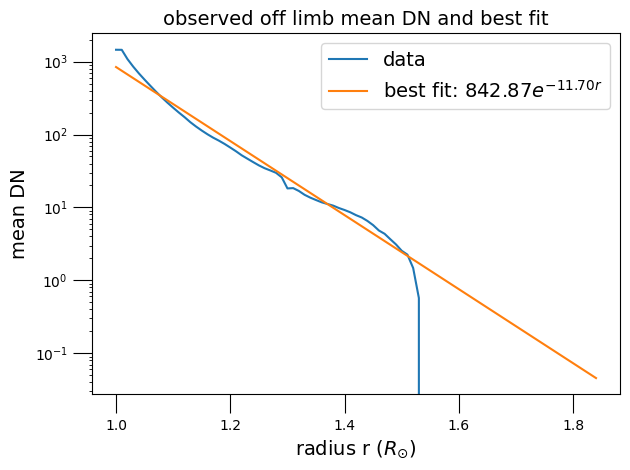

In [21]:
fontsize = 14
fig, ax = plt.subplots()

ax.plot(rsun_array, y, label='data')
best_fit = np.exp(np.poly1d(params)(rsun_array))
label = fr'best fit: {best_fit[0]:.2f}$e^{{{params[0]:.2f}r}}$'
ax.plot(rsun_array, best_fit, label=label)
ax.set_yscale('log')
ax.set_ylabel(r'mean DN', fontsize=fontsize)
ax.set_xlabel(r'radius r ($R_{\odot}$)', fontsize=fontsize)
ax.tick_params(axis='both', size=fontsize)
ax.set_title(r'observed off limb mean DN and best fit', fontsize=fontsize)
ax.legend(fontsize=fontsize)
fig.tight_layout()

plt.show()

In [22]:
# Create our normalization array. At solar radius and below, normalization is 1,
# while off-disk the normalization changes according to the fitted function above
scale_factor = np.exp((r-1)*-params[0])
scale_factor[r < 1] = 1

In [23]:
# Create a new map with the normalized off-disk emission.
# Set normalization of the new map to be same as original map to compare both
scaled_map = sunpy.map.Map(aia.data * scale_factor, aia.meta)
scaled_map.plot_settings['norm'] = ImageNormalize(stretch=aia.plot_settings['norm'].stretch)

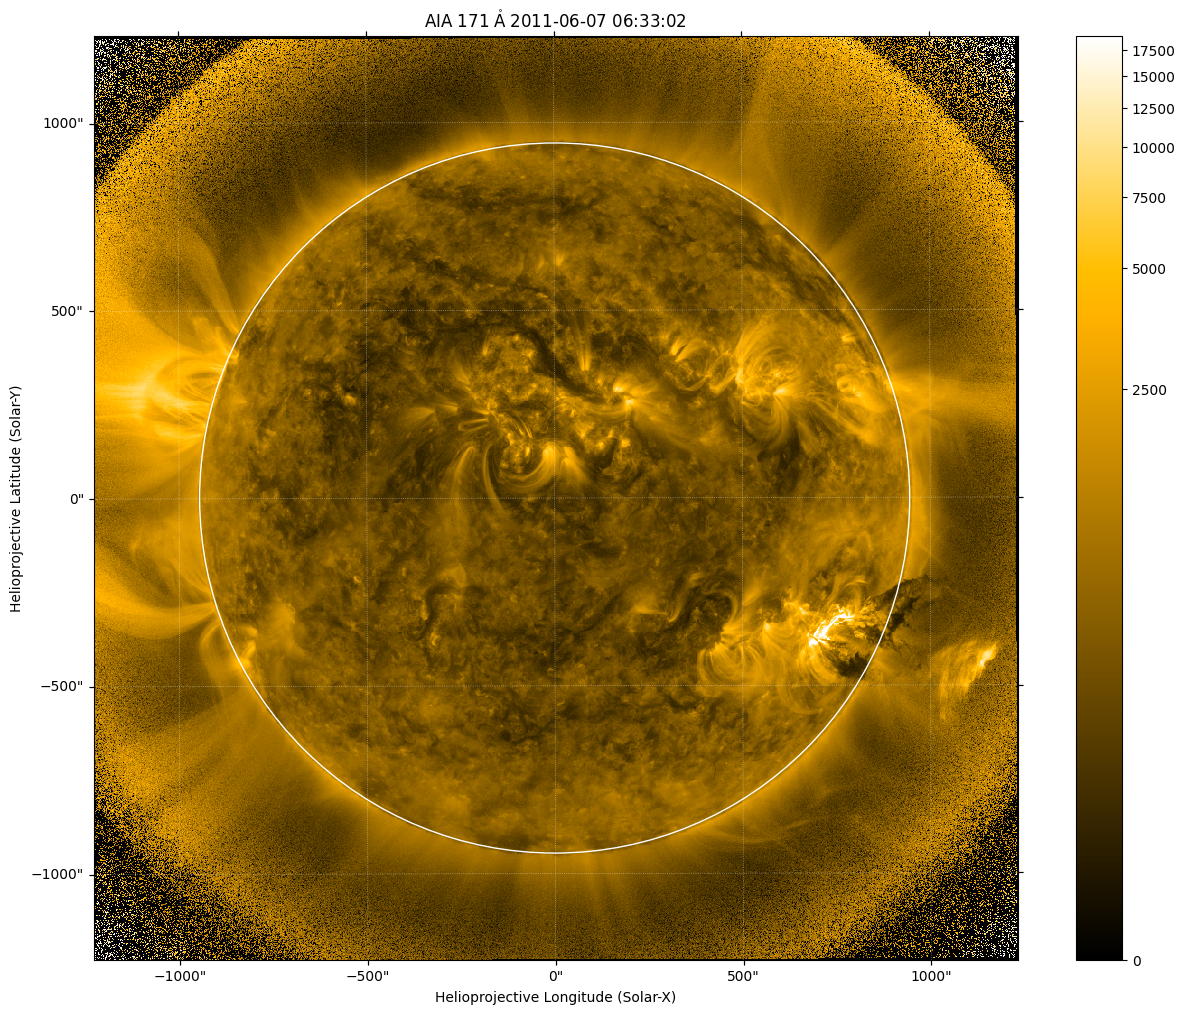

In [24]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(projection=scaled_map)
im = scaled_map.plot(axes=ax, clip_interval=(5, 99.9)*u.percent)
scaled_map.draw_limb(axes=ax)
fig.colorbar(im)
plt.show()